<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [69]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [70]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-11-25 01:10:55--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-11-25 01:10:56 (173 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [71]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [72]:
df.shape

(346, 10)

### Convert to date time object


In [73]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [74]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [75]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



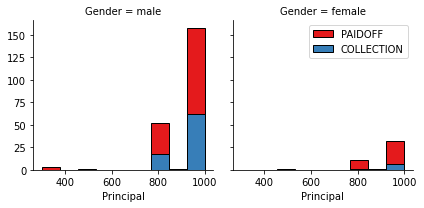

In [76]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

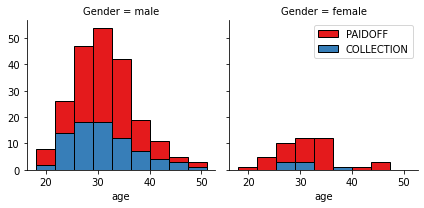

In [77]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


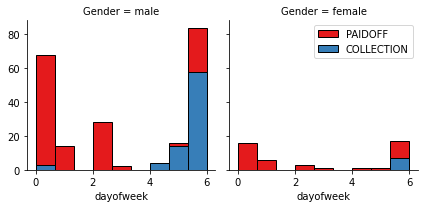

In [78]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [79]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [80]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [81]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [82]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [83]:
df[['Principal','terms','age','Gender','education','weekend']].head()

,Principal,terms,age,Gender,education,weekend
0,1000,30,45,0,High School or Below,0
1,1000,30,33,1,Bechalor,0
2,1000,15,27,0,college,0
3,1000,30,28,1,college,1
4,1000,30,29,0,college,1


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [84]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [85]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [86]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [87]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.52,  0.92,  2.33, -0.42, -1.21, -0.38,  1.14, -0.87],
       [ 0.52,  0.92,  0.34,  2.38, -1.21,  2.62, -0.88, -0.87],
       [ 0.52, -0.96, -0.65, -0.42, -1.21, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.49,  2.38,  0.83, -0.38, -0.88,  1.15],
       [ 0.52,  0.92, -0.32, -0.42,  0.83, -0.38, -0.88,  1.15]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [88]:
#train/test split data

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

The best accuracy was with 0.8365384615384616 with k= 34


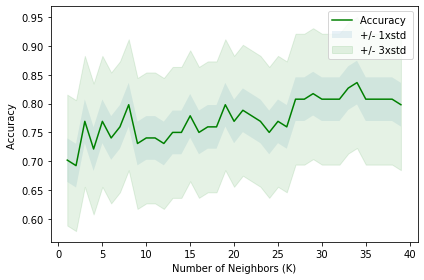

In [89]:
#import library for KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score


#fit, predict, and calc accuracy score
Ks = 40
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(x_train,y_train)
    yhat_K=neigh.predict(x_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat_K)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat_K.shape[0])

mean_acc

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

#plot accuracy of model

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Error Rate')

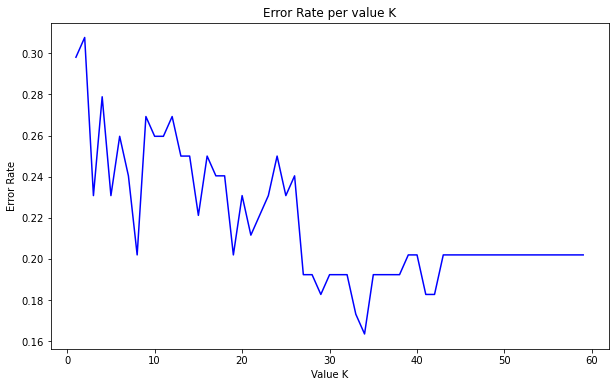

In [91]:
#Same as above, except using elbow method, since I already did this work before realizing there was a better method and didn't want to delete it 

#fit model, create loop, and calculate error rate
error_rate = []
K=range(1,60)

for n in K:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train,y_train)
    predict_y = knn.predict(x_test)
    error_rate.append(np.mean(predict_y != y_test))

#create elbow plot to determine optimal k

plt.figure(figsize=(10,6))
plt.plot(K, error_rate, color='blue')
plt.title('Error Rate per value K')
plt.xlabel('Value K')
plt.ylabel('Error Rate')

#the optimal K value is roughly 35, as the error rate increases after that point

# Decision Tree

In [93]:
#import the goods
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


#create object
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth=5)

In [94]:
#fit the model and predict
loanTree.fit(x_train,y_train)
tree_predict = loanTree.predict(x_test)

#evaluate model
#print('Decision Tree Accuracy:', metrics.accuracy_score(y_test, tree_predict))


[Text(548.0357142857142, 996.6, 'weekend <= -0.188\nentropy = 0.839\nsamples = 242\nvalue = [65, 177]\nclass = PAIDOFF'),
 Text(298.92857142857144, 815.4000000000001, 'age <= -0.404\nentropy = 0.144\nsamples = 98\nvalue = [2, 96]\nclass = PAIDOFF'),
 Text(199.28571428571428, 634.2, 'terms <= -0.019\nentropy = 0.286\nsamples = 40\nvalue = [2, 38]\nclass = PAIDOFF'),
 Text(99.64285714285714, 453.0, 'entropy = 0.0\nsamples = 23\nvalue = [0, 23]\nclass = PAIDOFF'),
 Text(298.92857142857144, 453.0, 'college <= 0.14\nentropy = 0.523\nsamples = 17\nvalue = [2, 15]\nclass = PAIDOFF'),
 Text(199.28571428571428, 271.79999999999995, 'entropy = 0.0\nsamples = 9\nvalue = [0, 9]\nclass = PAIDOFF'),
 Text(398.57142857142856, 271.79999999999995, 'age <= -0.985\nentropy = 0.811\nsamples = 8\nvalue = [2, 6]\nclass = PAIDOFF'),
 Text(298.92857142857144, 90.59999999999991, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]\nclass = PAIDOFF'),
 Text(498.21428571428567, 90.59999999999991, 'entropy = 0.971\nsamples

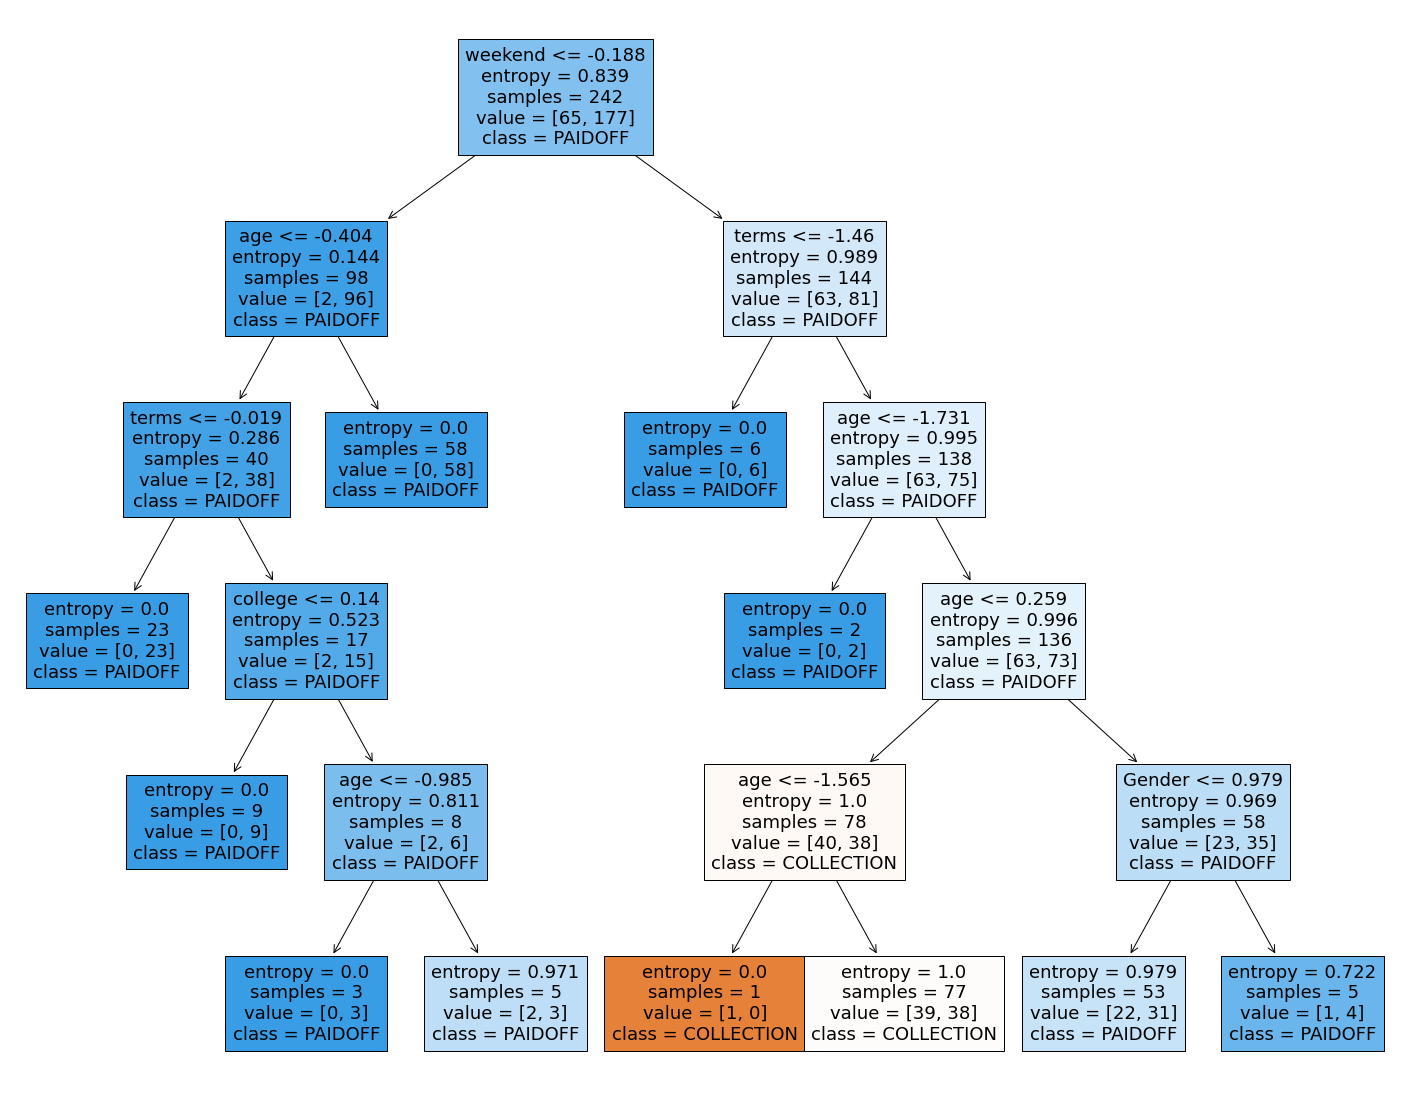

In [95]:
#import the visualization goods
!pip install pydotplus

from  io import StringIO
import matplotlib.image as mpimg
%matplotlib inline 

#visualization
fig = plt.figure(figsize=(25,20))
tree.plot_tree(loanTree, 
                   feature_names=Feature.columns,  
                   class_names=np.unique(y),
                   filled=True)


# Support Vector Machine


In [96]:
#import libraries
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn import svm

In [97]:
#train the model
clf = svm.SVC(kernel='rbf')
clf.fit(x_train, y_train)

#predict
yhat_svm = clf.predict(x_test)

In [98]:
#evaluation, f1 score
#from sklearn.metrics import f1_score
#f1_score(y_test, yhat_svm, average='weighted') 



0.7084533113944878

# Logistic Regression


In [48]:
#import libraries

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [99]:
#train model and predict
LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train, y_train)
yhat_LR=LR.predict(x_test)

#return probabalistic estimate
yhat_prob = LR.predict_proba(x_test)
yhat_prob

array([[0.51, 0.49],
       [0.47, 0.53],
       [0.44, 0.56],
       [0.52, 0.48],
       [0.31, 0.69],
       [0.32, 0.68],
       [0.51, 0.49],
       [0.29, 0.71],
       [0.52, 0.48],
       [0.46, 0.54],
       [0.5 , 0.5 ],
       [0.34, 0.66],
       [0.49, 0.51],
       [0.32, 0.68],
       [0.46, 0.54],
       [0.28, 0.72],
       [0.47, 0.53],
       [0.51, 0.49],
       [0.32, 0.68],
       [0.36, 0.64],
       [0.31, 0.69],
       [0.34, 0.66],
       [0.45, 0.55],
       [0.48, 0.52],
       [0.34, 0.66],
       [0.36, 0.64],
       [0.35, 0.65],
       [0.34, 0.66],
       [0.48, 0.52],
       [0.45, 0.55],
       [0.52, 0.48],
       [0.31, 0.69],
       [0.5 , 0.5 ],
       [0.35, 0.65],
       [0.32, 0.68],
       [0.47, 0.53],
       [0.36, 0.64],
       [0.45, 0.55],
       [0.5 , 0.5 ],
       [0.35, 0.65],
       [0.31, 0.69],
       [0.29, 0.71],
       [0.35, 0.65],
       [0.33, 0.67],
       [0.5 , 0.5 ],
       [0.5 , 0.5 ],
       [0.49, 0.51],
       [0.35,

In [58]:
#from sklearn.metrics import jaccard_score
#jaccard_score(y_test, yhat,pos_label='PAIDOFF')

0.7425742574257426

# Model Evaluation using Test set


In [100]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [101]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-11-25 01:19:43--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-11-25 01:19:43 (102 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [107]:
test_df = pd.read_csv('loan_test.csv')
#test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [129]:
#add weekend field
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])

test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

#Covert to one-hot
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

Feature1 = test_df[['Principal','terms','age','Gender','weekend']]
Feature1 = pd.concat([Feature1,pd.get_dummies(test_df['education'])], axis=1)
Feature1.drop(['Master or Above'], axis = 1,inplace=True)



#converting test data to array
X1 = Feature1
X1= preprocessing.StandardScaler().fit(X1).transform(X1)

y1 = test_df['loan_status']

#KNN
#predict
yhat_K1=neigh.predict(X1)


#Jaccard Score
from sklearn.metrics import jaccard_score

jaccard_score_K = jaccard_score(y1, yhat_K1, pos_label='PAIDOFF')
jaccard_score_K



#Decision Tree
#predict
tree_predict1 = loanTree.predict(X1)


#jaccard_score
jaccard_score_tree = jaccard_score(y1, tree_predict1, pos_label='PAIDOFF')
jaccard_score_tree

#SVM
#predict
yhat_svm1 = clf.predict(X1)

#jaccard_score
jaccard_score_svm = jaccard_score(y1, yhat_svm1, pos_label='PAIDOFF')
jaccard_score_svm



#Logistic Regression
#predict
yhat_LR1=LR.predict(X1)

#jaccard_score
jaccard_score_LR = jaccard_score(y1, yhat_LR1, pos_label='PAIDOFF')
jaccard_score_LR

print('Jaccard Score for KNN is:', jaccard_score_K, '\n Jaccard Score for Decision Tree is:', jaccard_score_tree, '\n Jaccard Score for SVM is:', jaccard_score_svm, '\n Jaccard Score for LR is:', jaccard_score_LR)



Jaccard Score for KNN is: 0.7843137254901961 
 Jaccard Score for Decision Tree is: 0.6444444444444445 
 Jaccard Score for SVM is: 0.7407407407407407 
 Jaccard Score for LR is: 0.7450980392156863


In [130]:
#F1 Scores
#KNN
F1_score_K = f1_score(y1, yhat_K1, average='weighted')

#Decision Tree
F1_score_tree = f1_score(y1, tree_predict1, average='weighted')

#SVM 
F1_score_svm = f1_score(y1, yhat_svm1, average='weighted')


#Logistic Regression
F1_score_LR = f1_score(y1, yhat_LR1, average='weighted')

print('F1 Score for KNN is:', F1_score_K, '\n F1 Score for Decision Tree is:', F1_score_tree, '\n F1 Score for SVM is:', F1_score_svm, '\n F1 Score for LR is:', F1_score_LR)


F1 Score for KNN is: 0.7427039191745074 
 F1 Score for Decision Tree is: 0.7178354825413649 
 F1 Score for SVM is: 0.6304176516942475 
 F1 Score for LR is: 0.7144140000438048


In [139]:
#One-hot-encode y1 and LR1
y2 = test_df['loan_status']
y2.replace(to_replace=['PAIDOFF','COLLECTIONS'], value=[0,1],inplace=True)


yhat_LR2 = pd.DataFrame(yhat_LR1, columns = ['loan_status']
#yhat_LR2.char.replace('PAIDOFF',0)


#LogLoss

#Logistic Regression
#from sklearn.metrics import log_loss
#Log_loss_score = log_loss(y2, yhat_LR1)

SyntaxError: unexpected EOF while parsing (3704362938.py, line 14)

# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
